# Plotting an SZ signal profile

The goal of this notebook is to plot equation 15 in [Arnaud et al. (2010)](https://ui.adsabs.harvard.edu/abs/2010A%26A...517A..92A/abstract) (A10). A10 defines the universal pressure profile (UPP) used in the ACT catalog.

In [1]:
## Import packages
import numpy as np
from scipy import integrate

from astropy import constants as const
from astropy.cosmology import LambdaCDM
from astropy import units as u

import matplotlib.pyplot as plt

## Universal pressure profile

### Define parameters + cosmology

In [2]:
## Various profile parameters
h_70 = 1.
std_cosmo = LambdaCDM(H0=70*h_70, Om0=0.3, Ode0=0.7)

# From Eq. (7)
alpha_P = 1/0.561 - 5/3

# From Eq. (12)
P_0, c_500, gamma, alpha, beta = 8.403 * h_70**(-3/2), 1.177, 0.3081, 1.0510, 5.4905

### Define formulas

In [3]:
def compute_R_500(M_500, z, cosmo):
    '''
    
    Compute the radius corresponding to a density contrast of 500 (R_500). 
    The returned value is a Quantity object.
    
    We use the following formula:
    
    3 * M_500 / (4 * pi * R_500^3) = 500 * rho_crit(z)
    
    where rho_crit(z) is a function of redshift.
    
    ARGUMENTS
    ---------
    M_500: mass for density contrast of 500; an astropy Quantity object
    z: redshift; unitless
    cosmo: model for cosmology; e.g. astropy.cosmology.LambdaCDM(...)
    
    '''
    
    if (type(M_500) != u.quantity.Quantity):
        raise TypeError('M_500 should be a Quantity object')

    rho_crit = cosmo.critical_density(z)
    
    return np.cbrt(3 * M_500 / (4 * np.pi) / (500 * rho_crit)).to(u.Mpc)

def alpha_P_prime(x):
    '''
    
    The function alpha_P'(x), as defined in Eq. (8). 
    
    The expression alpha(x) = alpha_P + alpha_P'(x) characterizes how
    the scaled pressure profile p(x) varies with mass. For more details,
    see subsection 3.4.
    
    ARGUMENTS
    ---------
    x: r / R_500. See Eq. (4).
    
    '''
    
    x_expression = (x/0.5)**3 / (1. + (x/0.5)**3)
    
    return 0.10 - (alpha_P + 0.10) * x_expression

def dimless_profile(x):
    '''
    
    Dimensionless pressure profile 𝕡(x), as defined in Eq. (11). 
    
    Warning: This is *different* from the scaled profile p(x) in Eq. (4). 
    The dimensionless profile is denoted with 'p' in the blackboard bold font.
    
    ARGUMENTS
    ---------
    x: r / R_500. See Eq. (4).
    
    '''
    
    denominator = (c_500*x)**gamma * \
                    (1 + (c_500*x)**alpha)**((beta-gamma)/alpha)
    
    return P_0 / denominator
    
def physical_profile(r, M_500, z):
    '''
    
    Physical pressure profile, as defined in Eq. (13). 
    Has units of keV/cm^3.
    
    ARGUMENTS
    ---------
    r: physical distance from cluster center
    M_500: M_500: mass for density contrast of 500; a Quantity object
    z: redshift; unitless
    
    '''
    
    if (type(M_500) != u.quantity.Quantity):
        raise TypeError('M_500 should be a Quantity object')
    
    # if r has no units, assume that it's in units of Mpc
    if (type(r) != u.quantity.Quantity):
        r *= u.Mpc 
    
    R_500 = compute_R_500(M_500, z, std_cosmo)
    x = r / R_500
    
    h_z = std_cosmo.H(z) / (100 * u.km / u.s / u.Mpc)
    mass_expression = (M_500 / 3e14 / const.M_sun * h_70)**(2/3 + alpha_P + alpha_P_prime(x))
    
    return 1.65e-3 * h_z**(8/3) * mass_expression * dimless_profile(x) * h_70**2 \
            * u.keV * u.cm**(-3)

### Debugging

In [4]:
## testing above functions
M_500 = 1e14 * const.M_sun
z = 1.2

R_500 = compute_R_500(M_500, z, std_cosmo)
print(f'R_500 for M_500={np.round(M_500 / const.M_sun / 1e14,1)}*10^14 M_sun and z={z}:')
print(np.round(R_500,3))

## plot dimensionless profile
# xs = np.linspace(0.01, 1, num=50)
# plt.plot(xs, dimless_profile(xs))
# plt.show()

## plot physical profile
# rs = np.linspace(0.01, 1, num=50) * u.Mpc
# plt.plot(rs, physical_profile(rs, M_500, z))
# plt.xlabel('Distance (Mpc)')
# plt.ylabel('Pressure (keV/cm^3)')
# plt.show()

R_500 for M_500=1.0*10^14 M_sun and z=1.2:
0.448 Mpc


## SZ signal formula

Note: scipy's `integrate` function doesn't accept Quantity objects as its integrand or its limits, so the proper units are tracked separately.

We can write the Y_cyl 'density' (signal strength at a given radius $r$) as:

$$Y_\text{cyl, dens}(r) = \frac{\sigma_T}{m_e c^2} \int_r^{R_b} \frac{2 P(r')r' dr'}{\sqrt{r'^2 - r^2}} $$

In [5]:
def Y_cyl_inner_integrand(y, x, M_500, z):
    '''
    
    Inner integrand used in compute_Y_cyl. Result has units of keV/cm^3.
    
    ARGUMENTS
    ---------
    y: r' in Eq. (15); should be given in Mpc
    x: r in Eq. (15); should be given in Mpc
    M_500: M_500: mass for density contrast of 500; a Quantity object
    z: redshift; unitless
    
    '''
    
    result = 2*physical_profile(y, M_500, z)*y / np.sqrt(y**2 - x**2)
    return result.value

def Y_cyl_integrand(y, x, M_500, z):
    '''
    
    Integrand used in compute_Y_cyl. Result has units of Mpc * keV/cm^3.
    
    ARGUMENTS
    ---------
    y: r' in Eq. (15); should be given in Mpc
    x: r in Eq. (15); should be given in Mpc
    M_500: M_500: mass for density contrast of 500; a Quantity object
    z: redshift; unitless
    
    '''
    
    result = 2*np.pi*x * Y_cyl_inner_integrand(y, x, M_500, z)
    return result.value

def compute_Y_cyl(R, M_500, z):
    '''
    
    Compute the volume-integrated Compton parameter Y within a radius R for
    a cylindrical volume of integration. See Eq. (15).
    
    NOTE: integrate doesn't accept Quantity objects, so the units of the
    integrand and the dummy variables (dy and dx) are multiplied back
    at the end.
    
    ARGUMENTS
    ---------
    R: physical distance from cluster center; should be given in Mpc
    M_500: M_500: mass for density contrast of 500; a Quantity object
    z: redshift; unitless
    
    '''
    
    if (type(R) == u.quantity.Quantity):
        raise TypeError('R should not be a Quantity') 
    
    R_500 = compute_R_500(M_500, z, std_cosmo)
    

    
    integral, abserror = integrate.dblquad(func=Y_cyl_integrand*x, a=0, b=R, \
                        gfun=(lambda x: x), hfun=(lambda x: 5*R_500/u.Mpc), args=(M_500, z))
    
    factor = const.sigma_T / (const.m_e*const.c**2)
#     print(f'integral: {integral}')
#     print(f'abserror: {abserror}')
    
    return (factor * integral * (u.Mpc * u.keV * u.cm**-3)).to(u.dimensionless_unscaled) \
                * u.Mpc**2

def compute_Y_cyl_dens(r, M_500, z):
    '''
    
    Compute the signal strength/'density' of Y_cyl at a given radius r. 
    This is the inner integral in Eq. (15). Result is unitless.
    
    NOTE: integrate doesn't accept Quantity objects, so the units of the
    integrand and the dummy variable are multiplied back at the end.
    
    ARGUMENTS
    ---------
    r: physical distance from cluster center; should be given in Mpc
    M_500: M_500: mass for density contrast of 500; a Quantity object
    z: redshift; unitless
    
    '''
    
    if (type(r) == u.quantity.Quantity):
        raise TypeError('r should not be a Quantity') 
    
    R_500 = compute_R_500(M_500, z, std_cosmo)
    integral, abserror = integrate.quad(func=Y_cyl_inner_integrand, a=r, b=5*R_500/u.Mpc, \
                        args=(r, M_500, z))
    factor = const.sigma_T / (const.m_e*const.c**2)
    
    return (factor * integral * (u.Mpc * u.keV * u.cm**-3)).to(u.dimensionless_unscaled)

In [6]:
## debugging integration
# print(Y_cyl_integrand(1, 0.5, M_500, z))

# print(integrate.quad(Y_cyl_integrand, 1, 2, args=(0.5, M_500, z)))

compute_Y_cyl_dens(1e-10, M_500, z)

<Quantity 2.01069821e-05>

## Plotting the profile

From Hilton et al. (2021): "we choose to characterize the SZ signal and survey completeness by selecting a single reference filter scale of angular size $\theta_{500c} = 2'.4$, which corresponds to a UPP-model cluster with mass $M_{500c} = 2 \times 10^{14} M_\odot$ at z = 0.4"

Below, we define $x$ as $x = r/R_{500}$.

In [ ]:
M_500 = 2e14 * const.M_sun
z = 0.4

num_points = 20
x_vals = np.linspace(1e-10, 2, num=num_points)
r_vals = (x_vals * R_500).value
y_vals = [compute_Y_cyl_dens(r, M_500, z) for r in r_vals]

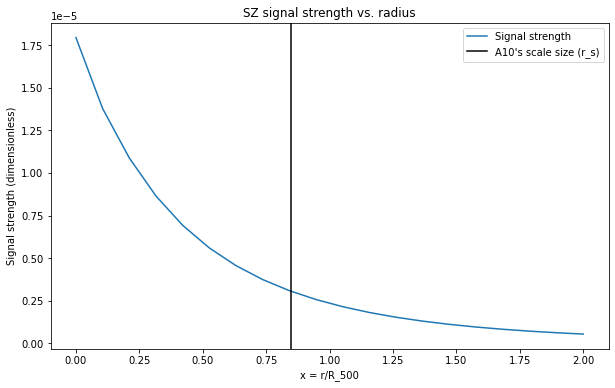

In [7]:
fig = plt.figure(figsize=(10, 6))

plt.plot(x_vals, y_vals, label='Signal strength')
plt.axvline(x=1/c_500, label="A10's scale size (r_s)", color='black')
plt.xlabel('x = r/R_500')
plt.ylabel('Signal strength (dimensionless)')

plt.title('SZ signal strength vs. radius')
plt.legend()
plt.show()

## Calculating FWHM and $\theta_c$

Let $r_c$ be the core radius, which is defined such that the FWHM is $2r_c/R_{500}$. ($r_c$ is **distinct** from the scale size $r_s$ mentioned in A10.) 

First, we calculate the FWHM and $r_c$:

In [11]:
half_max = y_vals[0] / 2
r_c = ...
fwhm = ...

<Quantity 8.97830131e-06>

Then, we calculate $\theta_c = r_c / d_A(z)$ ($d_A$ is a function of $z$):

In [ ]:
h = 0.7
cosmo = LambdaCDM(H0=100*h, Om0=0.3, Ode0=0.7)
d_A = cosmo.angular_diameter_distance(z).value # angular distance in Mpc